In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import sklearn.base as skb
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import sklearn.linear_model as sklm
import warnings
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from xgboost import XGBClassifier
import joblib
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import OrderedDict
warnings.filterwarnings('ignore')
import random
from nltk.corpus import wordnet
seed = 5
np.random.seed(seed)

sns.set_style('whitegrid')
plt.style.use('seaborn-deep')
plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.monospace'] = 'Ubunto Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.figsize'] = (12,8)

In [ ]:
#SENTIMENT_ANALYSIS_PART

In [ ]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN



def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

def sentiment_feedback(sentiment_df):

    sentiment_df.dropna()
    sentiment_df.mask(sentiment_df.eq('None')).dropna()
    sentiment_df.mask(sentiment_df.astype(object).eq('None')).dropna()
    sentiment_df = sentiment_df.replace(to_replace='None', value=np.nan).dropna()
    sentiment_df = sentiment_df.rename(columns={"content": "review"})

    sentiment_df["review_clean"] = sentiment_df["review"].apply(lambda x: clean_text(x))
    sentiment_df["summary_clean"] = sentiment_df["summary"].apply(lambda x: clean_text(x))

    sid = SentimentIntensityAnalyzer()
    sentiment_df["sentiments"] = sentiment_df["review"].apply(lambda x: sid.polarity_scores(x))
    sentiment_df = pd.concat([sentiment_df.drop(['sentiments'], axis=1), sentiment_df['sentiments'].apply(pd.Series)], axis=1)
    sentiment_df = sentiment_df.rename(columns={"neg": "neg_rw", "neu": "neu_rw","pos": "pos_rw", "compound": "compound_rw"})

    sentiment_df["sentiments_sm"] = sentiment_df["summary"].apply(lambda x: sid.polarity_scores(x))
    sentiment_df = pd.concat([sentiment_df.drop(['sentiments_sm'], axis=1), sentiment_df['sentiments_sm'].apply(pd.Series)], axis=1)
    sentiment_df = sentiment_df.rename(columns={"neg": "neg_sm", "neu": "neu_sm","pos": "pos_sm", "compound": "compound_sm"})
    sentiment_df = sentiment_df.rename(columns={"neg_rw": "neg", "neu_rw": "neu","pos_rw": "pos", "compound_rw": "compound"})

    # add number of characters column
    sentiment_df["nb_chars"] = sentiment_df["review"].apply(lambda x: len(x))
    sentiment_df["nb_chars_sm"] = sentiment_df["summary"].apply(lambda x: len(x))

    # add number of words column
    sentiment_df["nb_words"] = sentiment_df["review"].apply(lambda x: len(x.split(" ")))
    sentiment_df["nb_words_sm"] = sentiment_df["summary"].apply(lambda x: len(x.split(" ")))

    # transform each document into a vector data

    doc2vec_df = sentiment_df["review_clean"].apply(lambda x: doc2vec_model.infer_vector(x.split(" "))).apply(pd.Series)
    doc2vec_df.columns = ["doc2vec_rw_vector_" + str(x) for x in doc2vec_df.columns]
    sentiment_df = pd.concat([sentiment_df, doc2vec_df], axis=1)
    doc2vec_df_sm = sentiment_df["summary_clean"].apply(lambda x: doc2vec_model.infer_vector(x.split(" "))).apply(pd.Series)
    doc2vec_df_sm.columns = ["doc2vec_sm_vector_" + str(x) for x in doc2vec_df_sm.columns]
    sentiment_df = pd.concat([sentiment_df, doc2vec_df_sm], axis=1)



    # merge_clean = pd.concat([sentiment_df["review_clean"], sentiment_df["summary_clean"]], axis=1)
    # merge_clean = sentiment_df[["review_clean","summary_clean"]].apply(" ".join, axis=1)
    # merge_clean = merge_clean.apply(lambda x: x.split(" "))

    # merge_clean = merge_clean.apply(lambda x: list(OrderedDict.fromkeys(x)))
    # merge_clean = merge_clean.apply(lambda x: " ".join(x))
    merge_clean = sentiment_df[["review_clean", "summary_clean"]].apply(lambda x: " ".join(x), axis=1)
    merge_clean = merge_clean.apply(lambda x: list(OrderedDict.fromkeys(x.split(" "))))
    merge_clean = merge_clean.apply(lambda x: " ".join(x))

    tfidf_result = tfidf_vectorizer.transform(merge_clean).toarray()
    tfidf_df = pd.DataFrame(tfidf_result, columns=tfidf_vectorizer.get_feature_names_out())
    tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
    tfidf_df.index = sentiment_df.index
    sentiment_df = pd.concat([sentiment_df, tfidf_df], axis=1)

    sentiment_df = sentiment_df.loc[:, ~sentiment_df.columns.duplicated()].copy()

    ignore_cols = ["review", "review_clean", "summary",'summary_clean']
    features = [c for c in sentiment_df.columns if c not in ignore_cols]

    X_test = sentiment_df[features]

    y_pred_list = xgb.predict_proba(X_test)
    y_pred = [np.max(x) for x in y_pred_list]
    y_pred_f = xgb.predict(X_test)
    y_pred_f = list(y_pred_f)
    output_df = pd.DataFrame(list(zip(y_pred_f, y_pred)), columns=['sentiment','sent_score'])

    return output_df


CHURN PREDICTION PART

In [ ]:
# Завантаження Doc2Vec моделі
doc2vec_model = Doc2Vec.load('/content/drive/MyDrive/churn_prediction/models/sentimenta_doc2vec_model')

# Завантаження TfidfVectorizer
tfidf_vectorizer = joblib.load('/content/drive/MyDrive/churn_prediction/models/sentimenta_tfidf_model')

# Завантаження XGBClassifier
xgb = joblib.load('/content/drive/MyDrive/churn_prediction/models/sentimenta_xgb_model.pkl')
df = pd.read_csv('/content/drive/MyDrive/churn_prediction/data/customers/churn_train.csv')
df = df.rename(columns={"churn_score": "churn_risk_score", 'content':'feedback'})
df['region_category'] = df['region_category'].fillna('Other')
df['avg_transaction_value'] = df['avg_transaction_value'].apply(lambda x: x*0.01)

In [ ]:
to_sentiment_df = pd.DataFrame(df[['feedback','summary']], columns=['feedback','summary'])
to_sentiment_df = to_sentiment_df.rename(columns={'feedback':'content'})

In [ ]:
to_sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36988 entries, 0 to 36987
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  36988 non-null  object
 1   summary  36988 non-null  object
dtypes: object(2)
memory usage: 578.1+ KB


In [ ]:
output_sentiment_df = sentiment_feedback(to_sentiment_df)

In [ ]:
output_sentiment_df.index = df.index
df = pd.concat([df,output_sentiment_df], axis=1)

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/churn_prediction/data/customers/churn_test.csv')
df_test = df_test.rename(columns={'content':'feedback'})
df_test['region_category'] = df_test['region_category'].fillna('Other')
df_test['avg_transaction_value'] = df_test['avg_transaction_value'].apply(lambda x: x*0.01)

In [ ]:
to_sentiment_df_test = pd.DataFrame(df_test[['feedback','summary']], columns=['feedback','summary'])
to_sentiment_df_test = to_sentiment_df_test.rename(columns={'feedback':'content'})

In [ ]:
output_sentiment_df_test = sentiment_feedback(to_sentiment_df_test)

In [ ]:
output_sentiment_df_test.index = df_test.index
df_test = pd.concat([df_test,output_sentiment_df_test], axis=1)

In [ ]:
df=df.drop('Unnamed: 0', axis=1)
df_test=df_test.drop('Unnamed: 0', axis=1)
df_test=df_test.drop('sentiments', axis=1)

In [ ]:
df_test.shape

(19915, 25)

In [ ]:
targetFeature = 'churn_risk_score'

In [ ]:
# Spliting the dataset into numerical and categorical features

def datasetShape(df):
    rows,cols = df.shape
    print("The dataframe has "+ str(rows)+" No. of rows and "+str(cols)+" of columns")
def divideFeatures(df):
    numerical_features = df.select_dtypes(include=[np.number])
    categorical_features = df.select_dtypes(include=[object])
    return numerical_features, categorical_features


In [ ]:
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)
num_feature,cat_feature = divideFeatures(df)
num_feature

(36988, 26)
(36988, 26)


,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score,sentiment,sent_score
0,44,14,516.16,210.2700,500.690000,5,1,0.695214
1,37,11,53.27,252.3956,567.660000,5,0,0.982744
2,31,20,113.13,244.8366,663.060000,5,0,0.998133
3,42,19,429.11,445.5482,568.080000,5,0,0.534857
4,25,14,570.23,351.1993,699.700000,5,0,0.999150
...,...,...,...,...,...,...,...,...
36983,42,16,34.10,394.3910,1224.393346,3,0,1.000000
36984,34,18,33.68,51.9423,1011.270354,3,0,0.999704
36985,45,10,34.93,415.5893,703.030000,3,0,0.999878
36986,27,13,135.83,82.2568,748.570000,3,0,1.000000


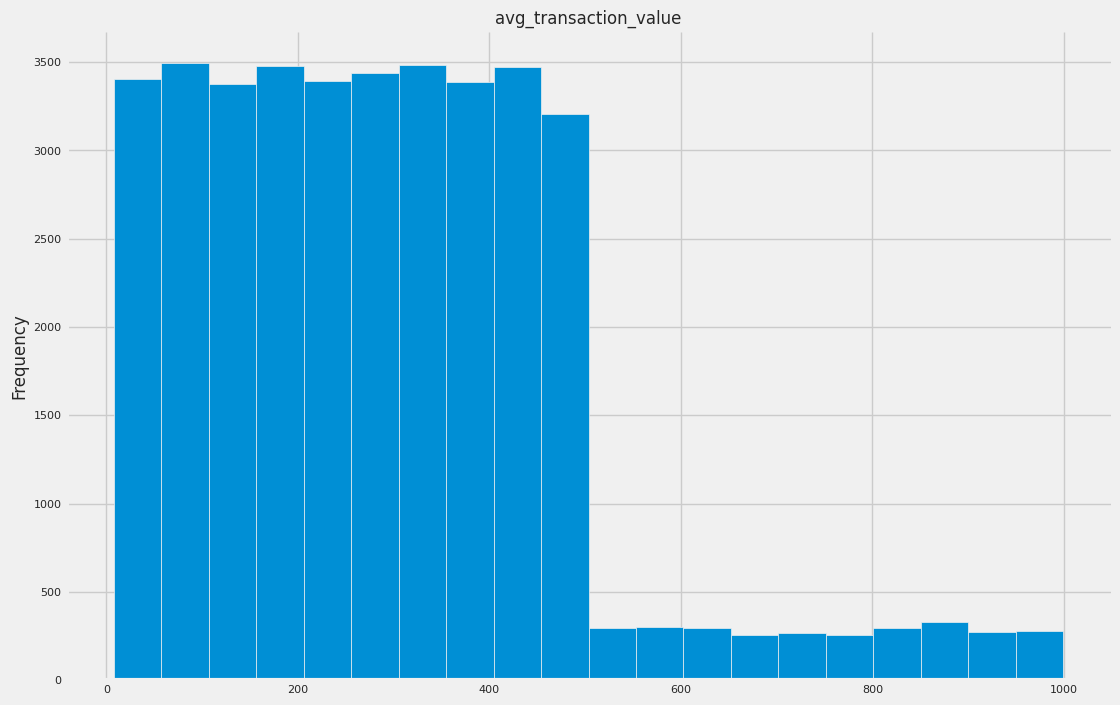

In [ ]:
# @title avg_transaction_value

from matplotlib import pyplot as plt
num_feature['avg_transaction_value'].plot(kind='hist', bins=20, title='avg_transaction_value')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
cat_feature

,customer_id,Name,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,avg_frequency_login_days,used_special_discount,offer_application_preference,feedback,summary
0,fffe4300490044003100390032003600,Merideth Mcmeen,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,Gift Vouchers/Coupons,Desktop,Wi-Fi,22:53:21,22.0,No,Yes,Ordered two sets. Jacked up car and used thes...,Not stable enough for me to crawl under.
1,fffe43004900440036003000330031003600,Eufemia Cardwell,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,Gift Vouchers/Coupons,Desktop,Mobile_Data,15:57:50,6.0,No,Yes,Very good product worked great,One Star
2,fffe43004900440031003900350030003600,Meghan Kosak,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,Credit/Debit Card Offers,Smartphone,Mobile_Data,15:46:44,16.0,No,Yes,"This product is as stated on website, however ...","Great product, terrible packaging and delivery."
3,fffe4300490044003800300035003800,Herma Torgeson,M,4UJ1551,Other,No Membership,2016-07-12,?,CID56614,Credit/Debit Card Offers,Both,Fiber_Optic,07:52:43,24.0,No,Yes,Part was completely wrong. Got some kind of Cu...,Wrong part - I mean completely wrong
4,fffe43004900440035003200390031003400,Mariana Hakes,F,OKZ6GDD,Village,Basic Membership,2016-05-22,Yes,CID19275,Gift Vouchers/Coupons,Both,Wi-Fi,05:57:20,8.0,Yes,Yes,OK quality but was a fraction too small to rep...,Fractionally too small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36983,fffe43004900440033003900370033003000,Rasheeda Ramsdell,F,OYJ0W89,Town,Premium Membership,2015-02-04,?,CID54811,Credit/Debit Card Offers,Desktop,Fiber_Optic,13:08:11,Error,Yes,No,"recommended by a car detailer as the cheap, gr...",It works like it should.
36984,fffe43004900440033003500330031003500,Genevieve Licht,M,YOG2LCF,City,Silver Membership,2016-02-16,Yes,CID62597,Credit/Debit Card Offers,Desktop,Mobile_Data,19:08:32,13.0,No,Yes,I bought the following products to use in the ...,Meguiar's G7164 Gold Class Car Wash Shampoo
36985,fffe43004900440033003600330033003800,Leslie Bruneau,F,I2TAL7N,Other,Premium Membership,2016-08-31,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi,08:30:41,19.0,Yes,No,use it first after you love it,use it first after you love it
36986,fffe43004900440034003900300036003500,Marlena Chastain,M,8X0LUUS,Town,Platinum Membership,2015-09-07,Yes,CID15800,Credit/Debit Card Offers,Desktop,Mobile_Data,05:29:19,16.0,Yes,No,"This is an excellent product! It's a car ""sham...","Perfect car ""shampoo & CONDITIONER""!"


In [ ]:
df.drop(['customer_id','Name','security_no','referral_id'],axis=1,inplace=True)
df_test.drop(['customer_id','Name','security_no','referral_id'],axis=1,inplace=True)

In [ ]:
num_feature,cat_feature = divideFeatures(df)
num_feature

,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score,sentiment,sent_score
0,44,14,516.16,210.2700,500.690000,5,1,0.695214
1,37,11,53.27,252.3956,567.660000,5,0,0.982744
2,31,20,113.13,244.8366,663.060000,5,0,0.998133
3,42,19,429.11,445.5482,568.080000,5,0,0.534857
4,25,14,570.23,351.1993,699.700000,5,0,0.999150
...,...,...,...,...,...,...,...,...
36983,42,16,34.10,394.3910,1224.393346,3,0,1.000000
36984,34,18,33.68,51.9423,1011.270354,3,0,0.999704
36985,45,10,34.93,415.5893,703.030000,3,0,0.999878
36986,27,13,135.83,82.2568,748.570000,3,0,1.000000


In [ ]:
cat_feature.nunique()

,0
gender,3
region_category,4
membership_category,6
joining_date,1096
joined_through_referral,3
preferred_offer_types,3
medium_of_operation,4
internet_option,3
last_visit_time,30098
avg_frequency_login_days,1654


In [ ]:
cat_feature['joining_date']

,joining_date
0,2016-11-11
1,2016-10-29
2,2017-09-12
3,2016-07-12
4,2016-05-22
...,...
36983,2015-02-04
36984,2016-02-16
36985,2016-08-31
36986,2015-09-07


In [ ]:
cat_feature['last_visit_time']

,last_visit_time
0,22:53:21
1,15:57:50
2,15:46:44
3,07:52:43
4,05:57:20
...,...
36983,13:08:11
36984,19:08:32
36985,08:30:41
36986,05:29:19


In [ ]:
cat_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36988 entries, 0 to 36987
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   gender                        36988 non-null  object
 1   region_category               36988 non-null  object
 2   membership_category           36988 non-null  object
 3   joining_date                  36988 non-null  object
 4   joined_through_referral       36988 non-null  object
 5   preferred_offer_types         36700 non-null  object
 6   medium_of_operation           36988 non-null  object
 7   internet_option               36988 non-null  object
 8   last_visit_time               36988 non-null  object
 9   avg_frequency_login_days      36988 non-null  object
 10  used_special_discount         36988 non-null  object
 11  offer_application_preference  36988 non-null  object
 12  feedback                      36988 non-null  object
 13  summary         

In [ ]:
cat_feature['avg_frequency_login_days'].replace(['Error'],np.nan,inplace=True)

In [ ]:
arr = cat_feature['avg_frequency_login_days'].unique()

<Axes: >

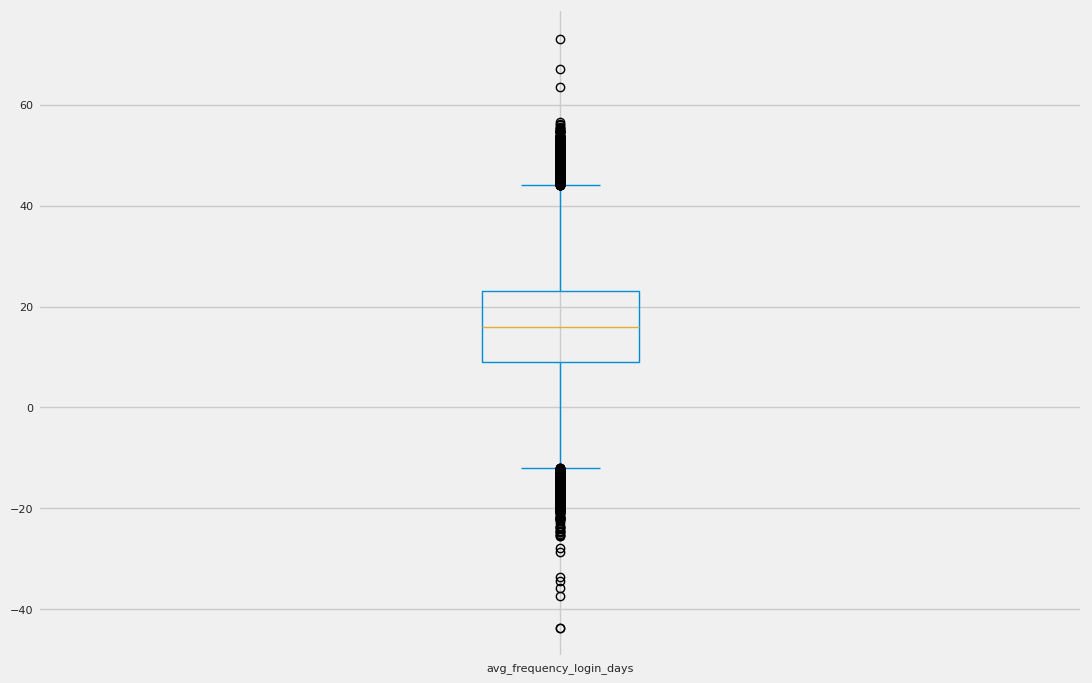

In [ ]:
cat_feature['avg_frequency_login_days'].astype('float64').plot(kind='box')

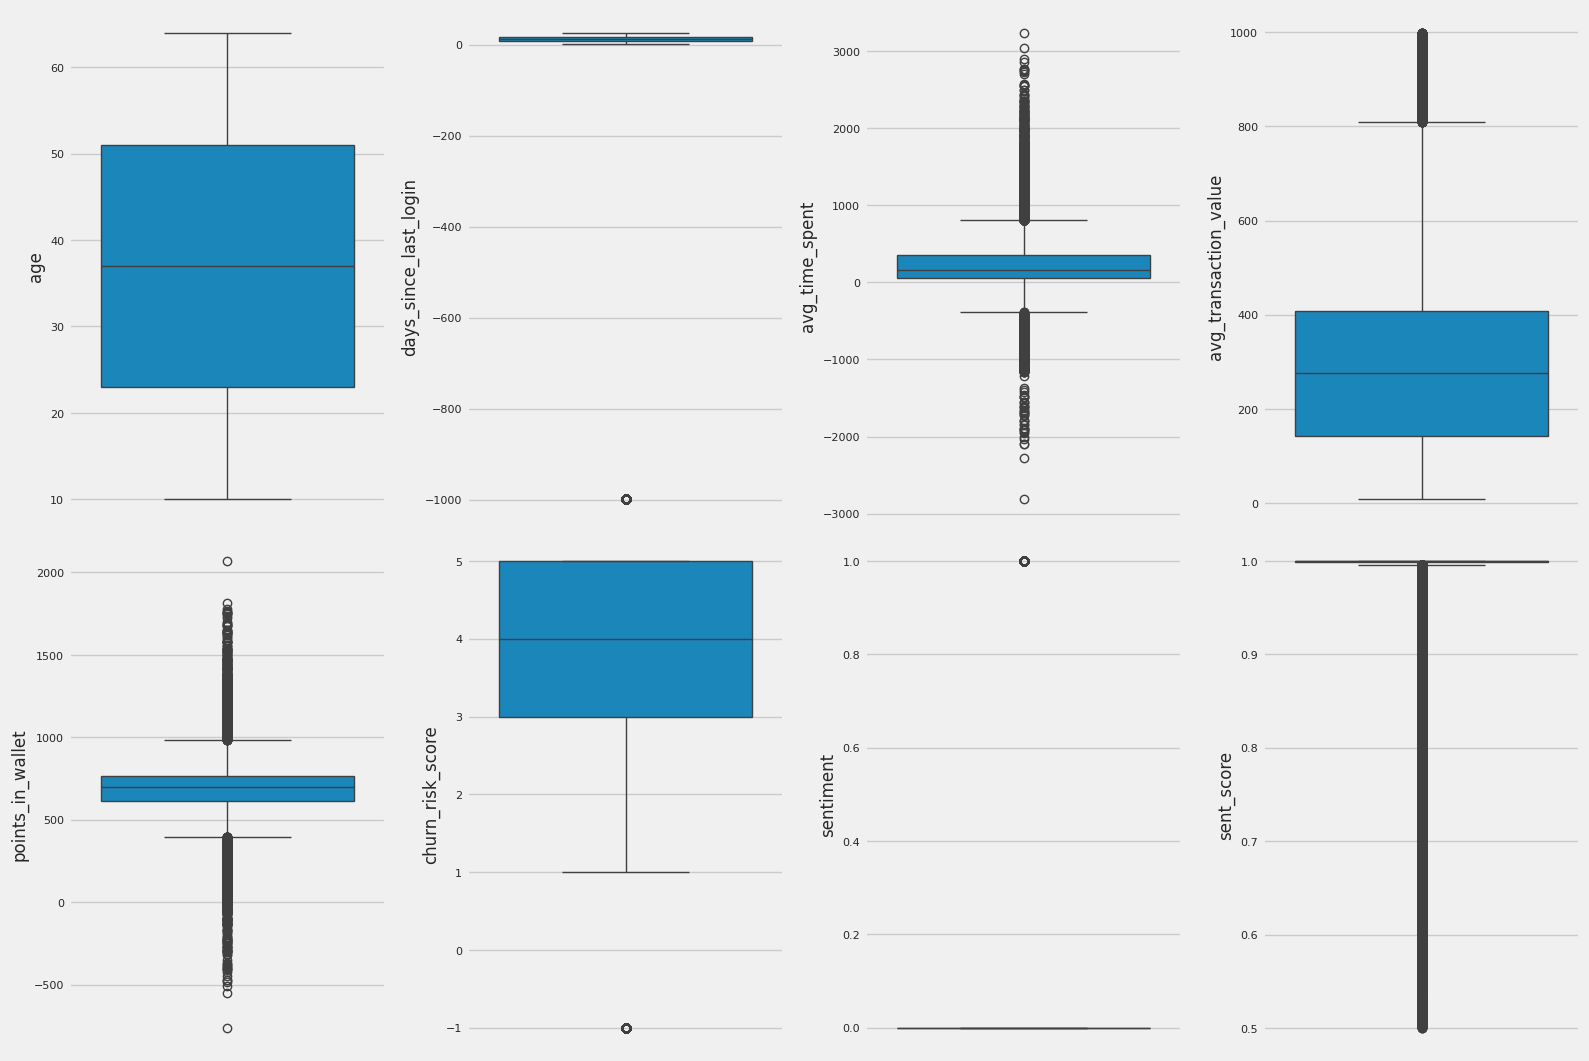

In [ ]:
fig = plt.figure(figsize=(16,16))
for i in range(len(num_feature.columns)):
    fig.add_subplot(3,4,i+1)
    sns.boxplot(y=num_feature.iloc[:,i])
plt.tight_layout()
plt.show()

In [ ]:
df['avg_frequency_login_days'].replace(['Error'],np.nan,inplace=True)
df_test['avg_frequency_login_days'].replace(['Error'],np.nan,inplace=True)

In [ ]:
df['avg_frequency_login_days'] = df['avg_frequency_login_days'].astype('float64')
df_test['avg_frequency_login_days'] = df_test['avg_frequency_login_days'].astype('float64')

In [ ]:
num_feature,cat_feature = divideFeatures(df)
num_feature

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score,sentiment,sent_score
0,44,14,516.16,210.2700,22.0,500.690000,5,1,0.695214
1,37,11,53.27,252.3956,6.0,567.660000,5,0,0.982744
2,31,20,113.13,244.8366,16.0,663.060000,5,0,0.998133
3,42,19,429.11,445.5482,24.0,568.080000,5,0,0.534857
4,25,14,570.23,351.1993,8.0,699.700000,5,0,0.999150
...,...,...,...,...,...,...,...,...,...
36983,42,16,34.10,394.3910,NaN,1224.393346,3,0,1.000000
36984,34,18,33.68,51.9423,13.0,1011.270354,3,0,0.999704
36985,45,10,34.93,415.5893,19.0,703.030000,3,0,0.999878
36986,27,13,135.83,82.2568,16.0,748.570000,3,0,1.000000


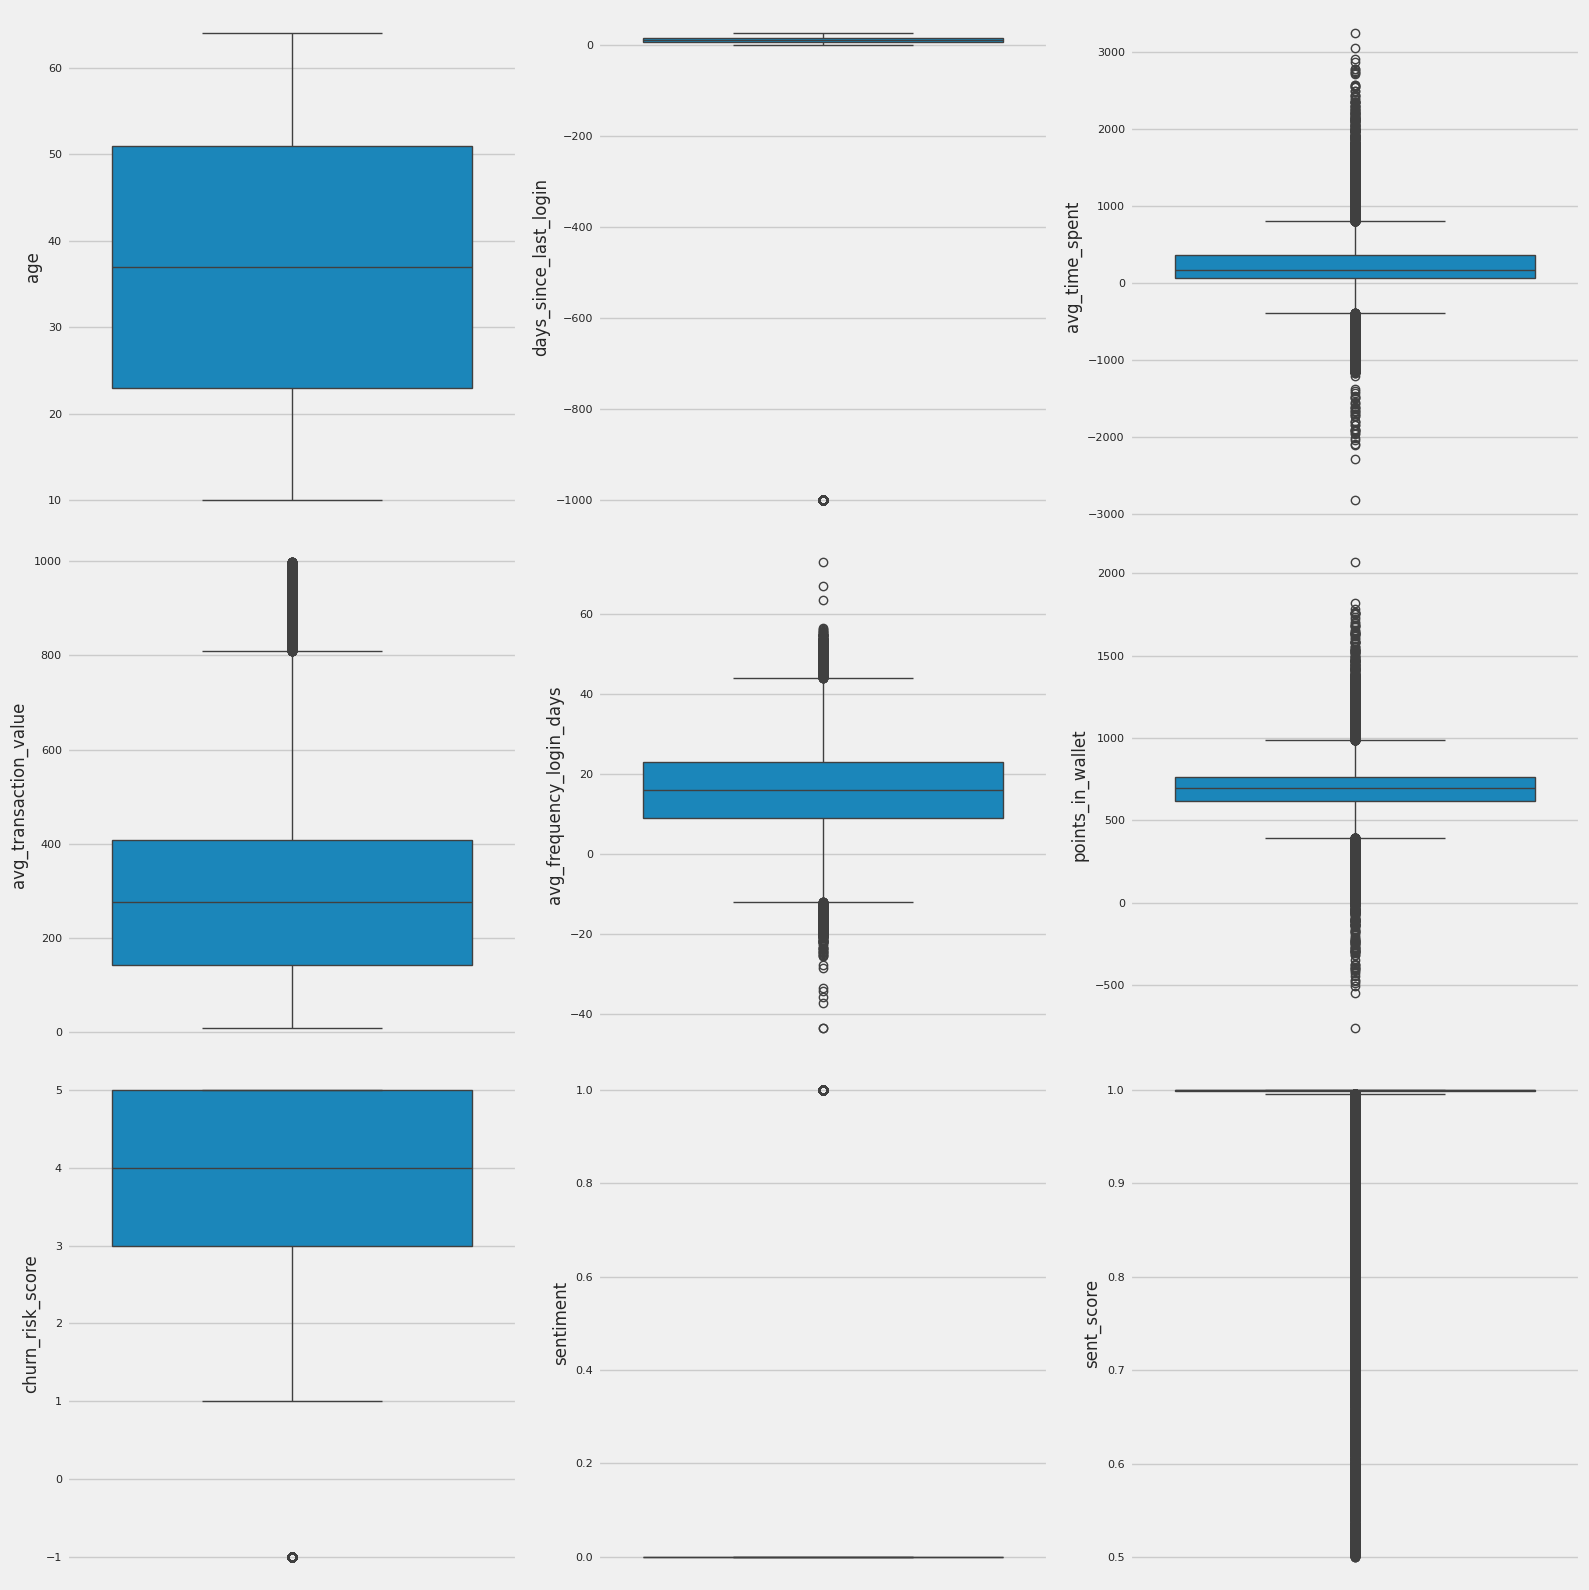

In [ ]:
fig = plt.figure(figsize=(16,16))
for i in range(len(num_feature.columns)):
    fig.add_subplot(3,3,i+1)
    sns.boxplot(y=num_feature.iloc[:,i])
plt.tight_layout()
plt.show()

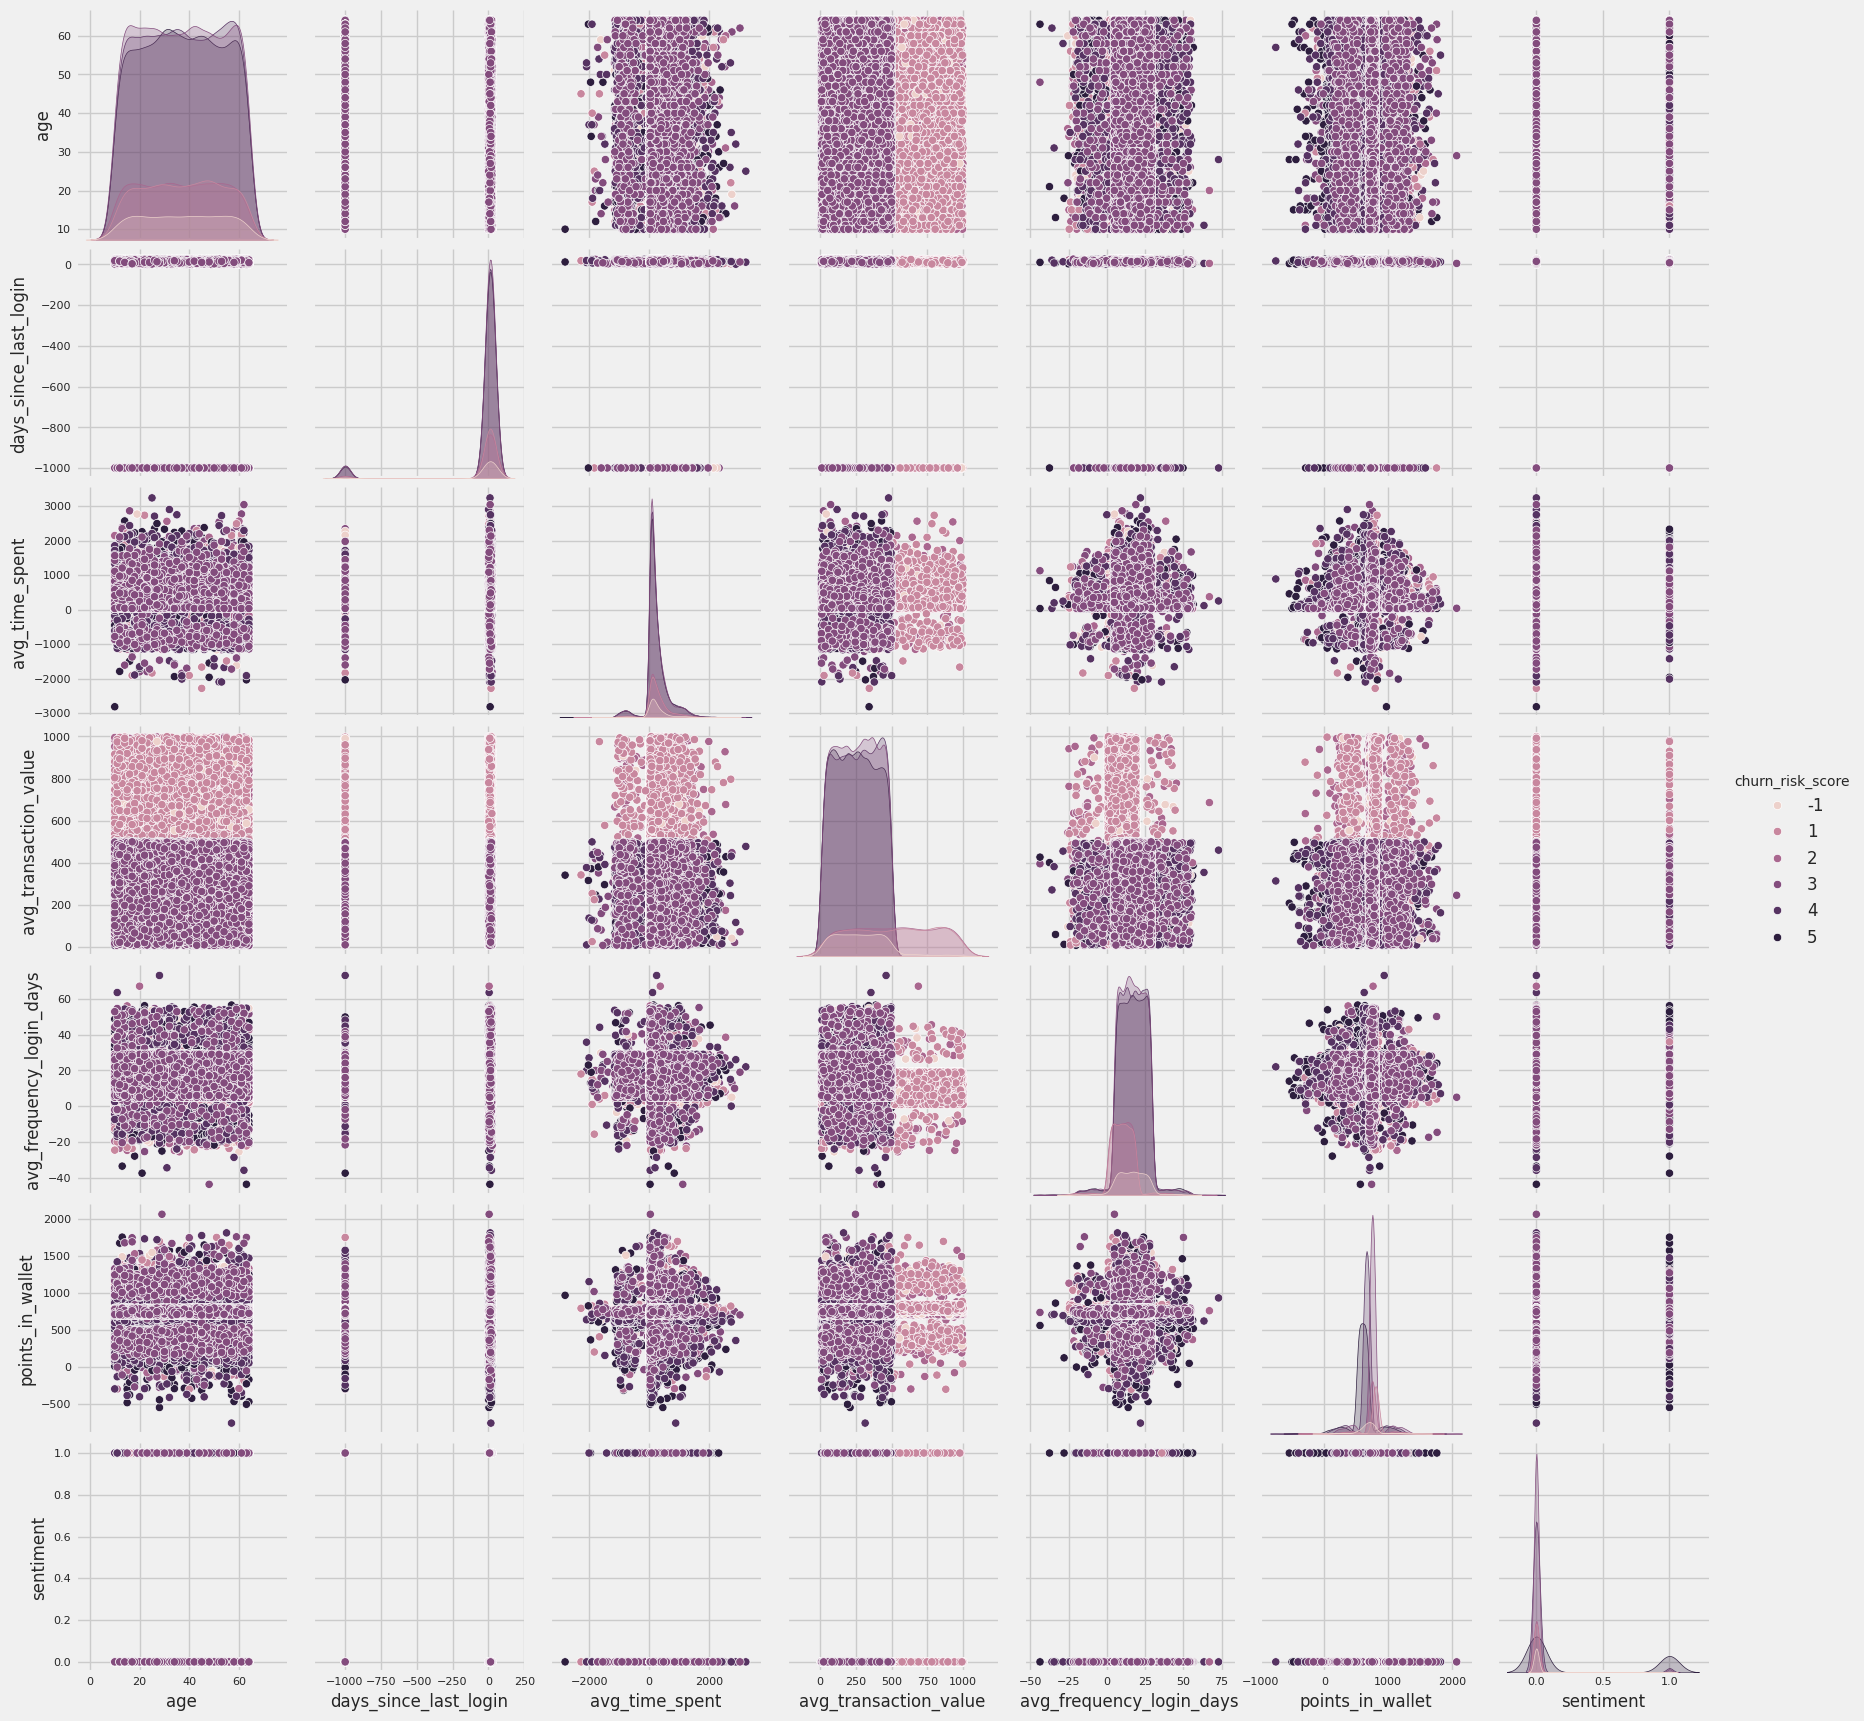

In [ ]:
sns.pairplot(df[['age','days_since_last_login','avg_time_spent','avg_transaction_value','avg_frequency_login_days','points_in_wallet','churn_risk_score','sentiment']],hue='churn_risk_score')
plt.show()

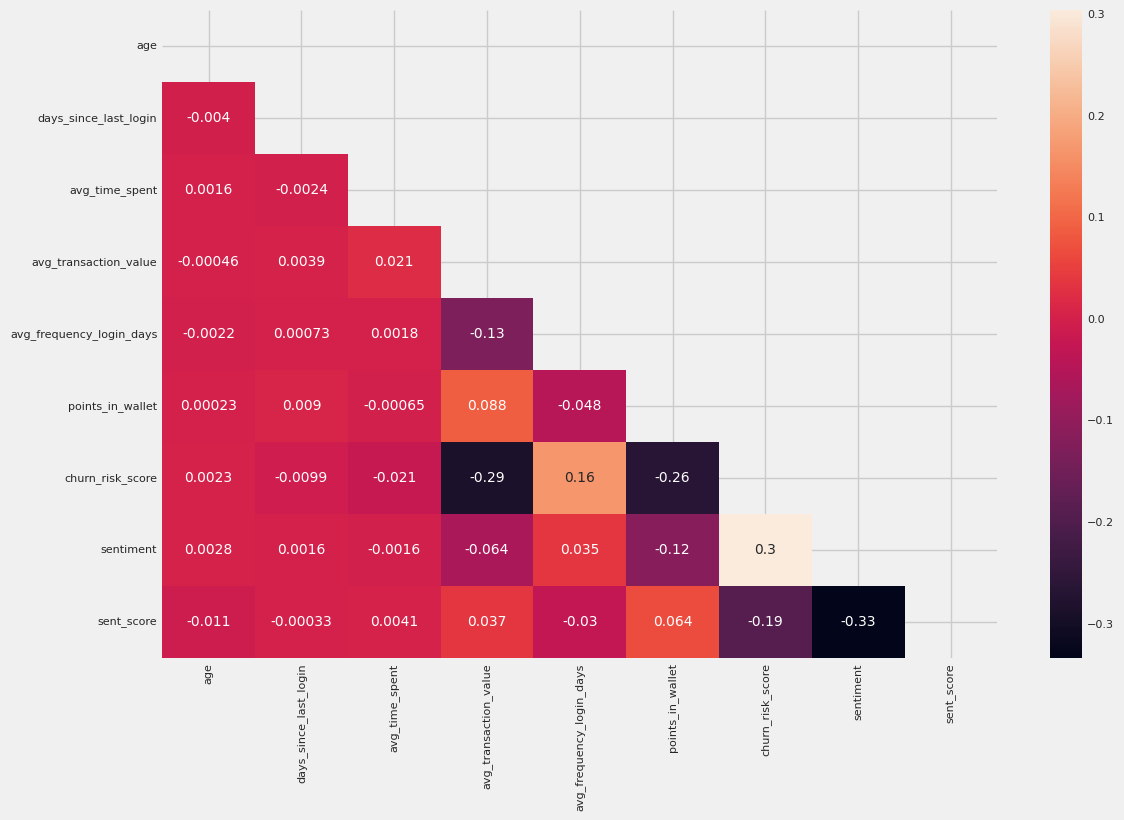

In [ ]:
corr = num_feature.corr()
mask = np.zeros_like(corr,dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,mask=mask,annot=True)
plt.show()

In [ ]:
skewed_features = num_feature.apply(lambda x:x.skew()).sort_values(ascending=False)
skewed_features

,0
sentiment,2.737010
avg_transaction_value,1.011007
avg_time_spent,0.539551
avg_frequency_login_days,0.005727
age,-0.007258
points_in_wallet,-0.080346
churn_risk_score,-1.114388
days_since_last_login,-3.941104
sent_score,-4.080074


In [ ]:
df.isnull().sum()

,0
age,0
gender,0
region_category,0
membership_category,0
joining_date,0
joined_through_referral,0
preferred_offer_types,288
medium_of_operation,0
internet_option,0
last_visit_time,0


In [ ]:
df.region_category.value_counts()

,count
region_category,
Town,14127
City,12736
Other,5426
Village,4699


<Axes: xlabel='sentiment', ylabel='churn_risk_score'>

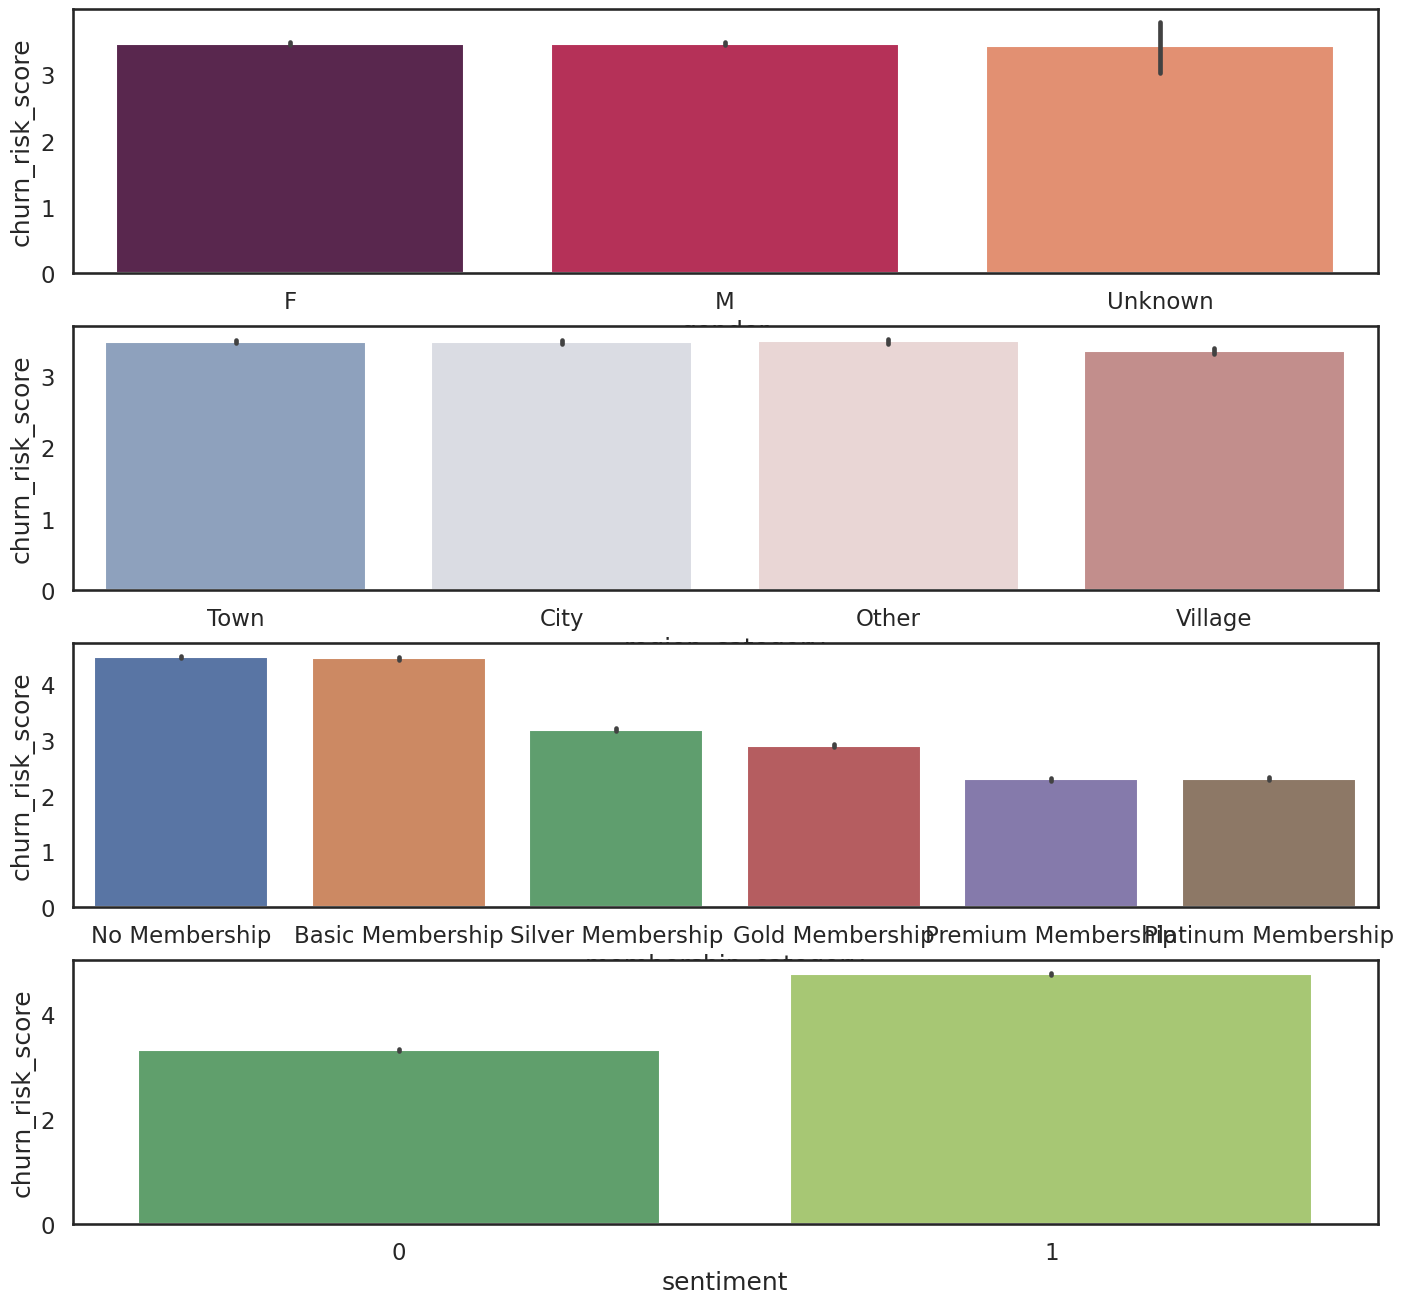

In [ ]:
sns.set_theme(style="white", context="talk")
f,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,15))
sns.barplot(x = 'gender',y =targetFeature,palette="rocket",ax=ax1,data=df)
sns.barplot(x = 'region_category',y =targetFeature,palette="vlag",ax=ax2,data=df)
sns.barplot(x = 'membership_category',y =targetFeature,palette="deep",ax=ax3,data=df)
sns.barplot(x = 'sentiment',y =targetFeature,palette="summer",ax=ax4,data=df)

<Axes: xlabel='churn_risk_score', ylabel='region_category'>

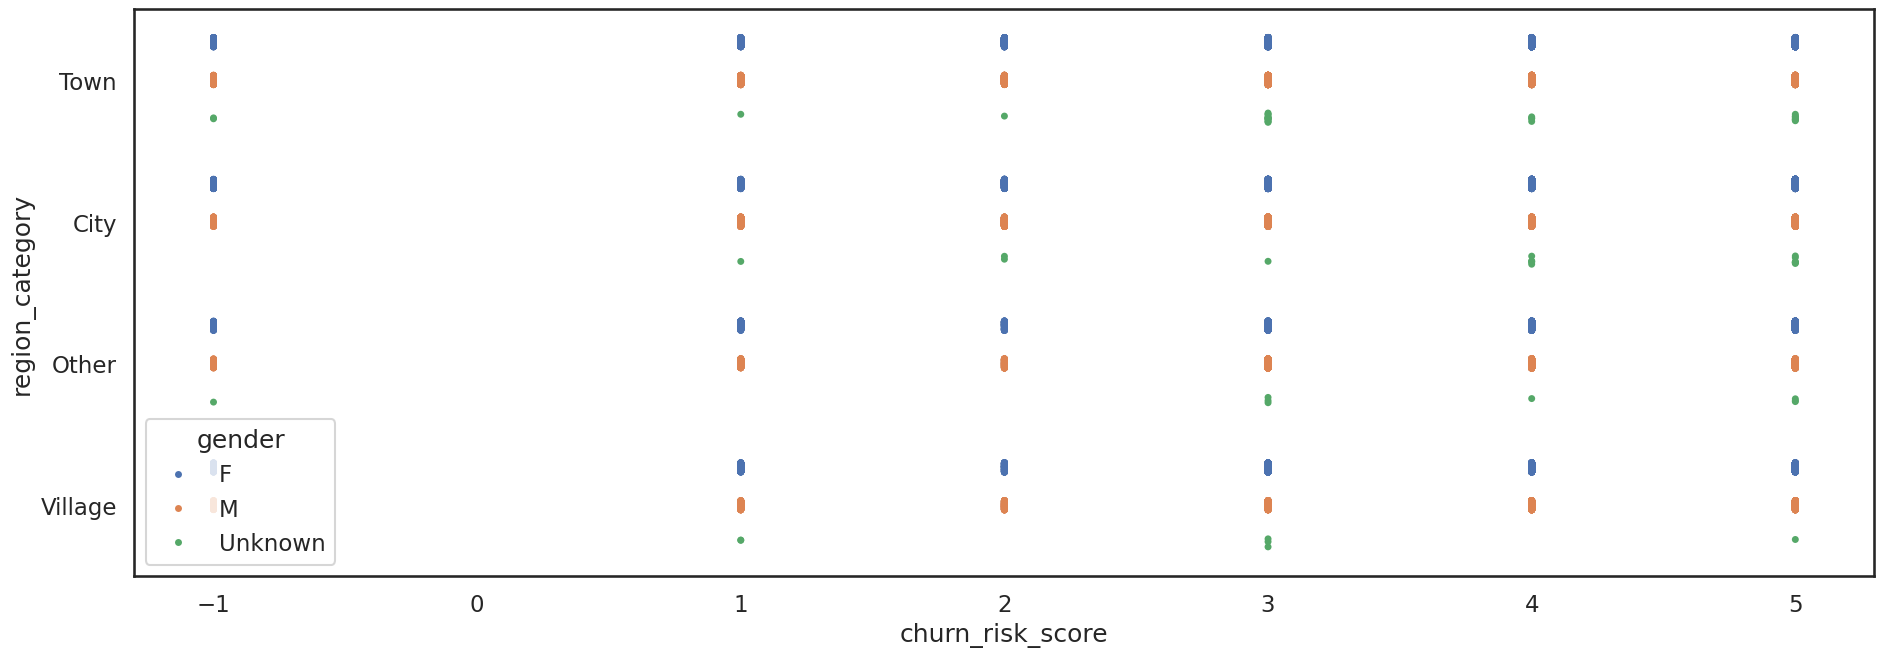

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,7))
sns.stripplot(y ='region_category', x =targetFeature, data = df, jitter = True, hue ='gender', dodge = True,ax=ax)

<Axes: xlabel='churn_risk_score', ylabel='sentiment'>

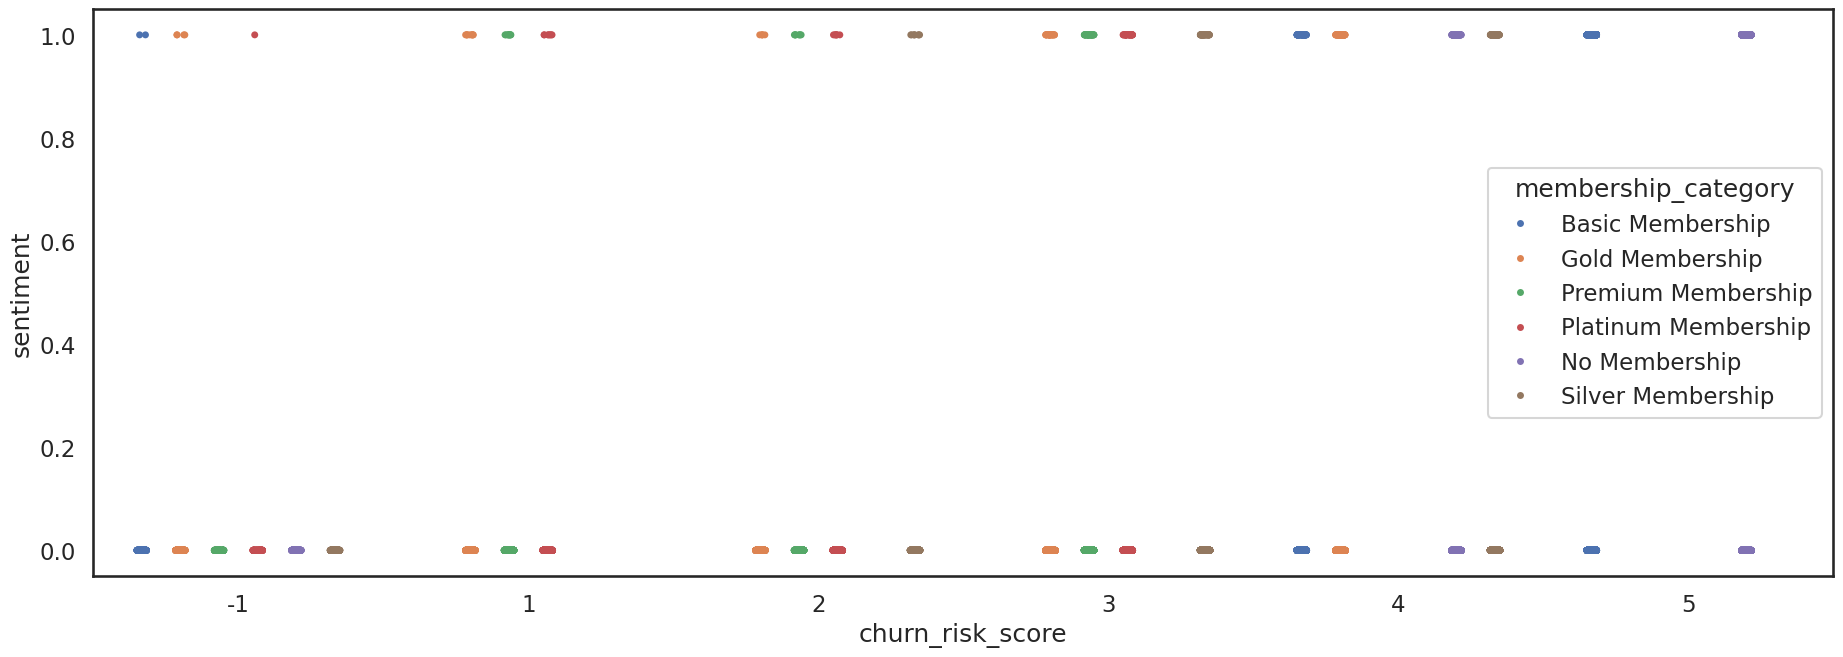

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,7))
sns.stripplot(y ='sentiment', x =targetFeature, data = df, jitter = True, hue ='membership_category', dodge = True,ax=ax)

<Axes: >

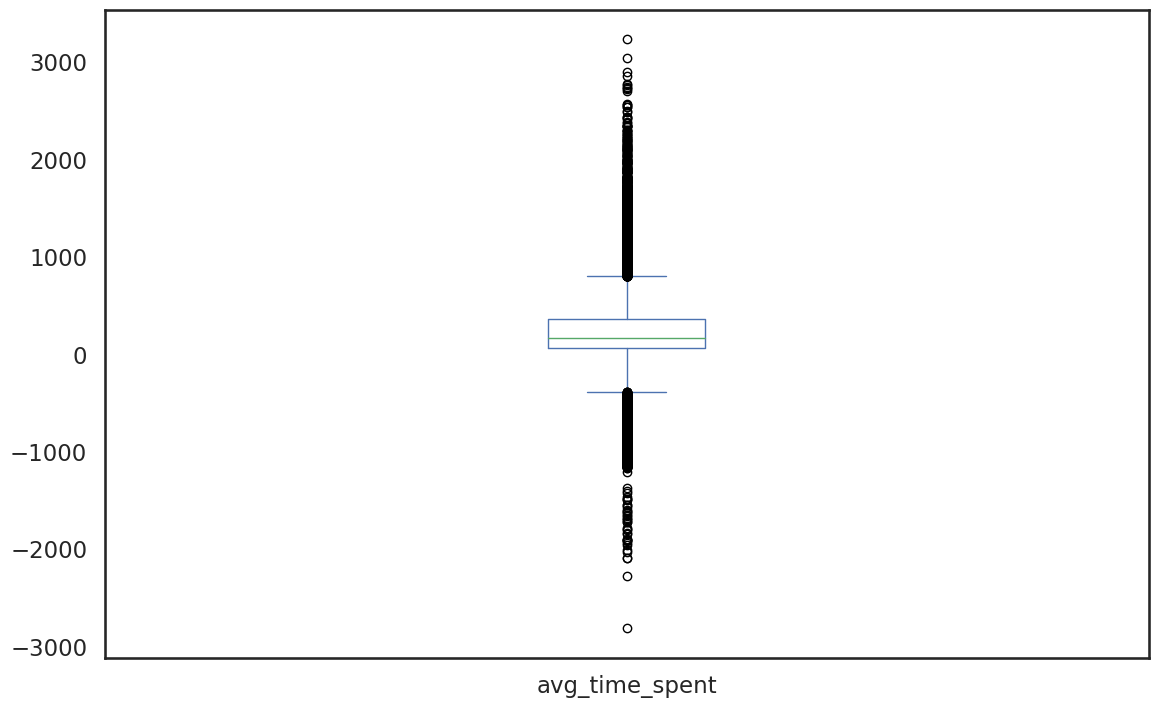

In [ ]:
df['avg_time_spent'].plot(kind='box')

In [ ]:
# Dropping all rows whose 'avg_time_spent' is negative
low = df['avg_time_spent'] < 0
low = np.where(low)
df.drop(low[0],inplace=True)

In [ ]:
df.isnull().sum()

,0
age,0
gender,0
region_category,0
membership_category,0
joining_date,0
joined_through_referral,0
preferred_offer_types,273
medium_of_operation,0
internet_option,0
last_visit_time,0


In [ ]:
# Reseting the default index
df.index = range(0,df.shape[0])

In [ ]:
# Dropping all rows whose 'points_in_wallet' is negative
l1 = np.where(df['points_in_wallet'] < 0)
df.drop(l1[0],inplace=True)
df.index = range(0,df.shape[0])

In [ ]:
# Dropping all rows whose 'avg_frequency_login_days' is negative
l2 = np.where(df['avg_frequency_login_days'] < 0)
df.drop(l2[0],inplace=True)
df.index = range(0,df.shape[0])

In [ ]:
# Dropping all rows whose 'avg_transaction_value' is negative
l3 = np.where(df['avg_transaction_value'] < 0)
df.drop(l3[0],inplace=True)
df.index = range(0,df.shape[0])

In [ ]:
# Dropping all rows whose 'days_since_last_login' is negative
l4 = np.where(df['days_since_last_login'] < 0)
df.drop(l4[0],inplace=True)
df.index = range(0,df.shape[0])

In [ ]:
df.dropna(how='any',inplace=True)

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19915 entries, 0 to 19914
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           19915 non-null  int64  
 1   gender                        19915 non-null  object 
 2   region_category               19915 non-null  object 
 3   membership_category           19915 non-null  object 
 4   joining_date                  19915 non-null  object 
 5   joined_through_referral       19915 non-null  object 
 6   preferred_offer_types         19756 non-null  object 
 7   medium_of_operation           19915 non-null  object 
 8   internet_option               19915 non-null  object 
 9   last_visit_time               19915 non-null  object 
 10  days_since_last_login         19915 non-null  int64  
 11  avg_time_spent                19915 non-null  float64
 12  avg_transaction_value         19915 non-null  float64
 13  a

In [ ]:
df['joining_date'] = pd.to_datetime(df['joining_date'])
df['last_visit_time'] = pd.to_datetime(df['last_visit_time'])

df_test['joining_date'] = pd.to_datetime(df_test['joining_date'])
df_test['last_visit_time'] = pd.to_datetime(df_test['last_visit_time'])

In [ ]:
df['jday'] = df['joining_date'].dt.day
df_test['jday'] = df_test['joining_date'].dt.day

In [ ]:
df['jday'] = df['joining_date'].dt.day
df['jmonth'] = df['joining_date'].dt.month
df['jweek'] = df['joining_date'].dt.dayofweek
df_test['jday'] = df_test['joining_date'].dt.day
df_test['jmonth'] = df_test['joining_date'].dt.month
df_test['jweek'] = df_test['joining_date'].dt.dayofweek

In [ ]:
df['diff'] =  ((df['last_visit_time'] - df['joining_date']).apply(lambda x:str(x).split()[0])).astype('float64')
df_test['diff'] =  ((df_test['last_visit_time'] - df_test['joining_date']).apply(lambda x:str(x).split()[0])).astype('float64')

In [ ]:
df

,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,...,offer_application_preference,churn_risk_score,feedback,summary,sentiment,sent_score,jday,jmonth,jweek,diff
0,44,F,Town,No Membership,2016-11-11,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,2024-08-15 22:53:21,...,Yes,5,Ordered two sets. Jacked up car and used thes...,Not stable enough for me to crawl under.,1,0.695214,11,11,4,2834.0
1,37,M,City,No Membership,2016-10-29,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,2024-08-15 15:57:50,...,Yes,5,Very good product worked great,One Star,0,0.982744,29,10,5,2847.0
2,31,F,City,No Membership,2017-09-12,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,2024-08-15 15:46:44,...,Yes,5,"This product is as stated on website, however ...","Great product, terrible packaging and delivery.",0,0.998133,12,9,1,2529.0
3,42,M,Other,No Membership,2016-07-12,?,Credit/Debit Card Offers,Both,Fiber_Optic,2024-08-15 07:52:43,...,Yes,5,Part was completely wrong. Got some kind of Cu...,Wrong part - I mean completely wrong,0,0.534857,12,7,1,2956.0
4,25,F,Village,Basic Membership,2016-05-22,Yes,Gift Vouchers/Coupons,Both,Wi-Fi,2024-08-15 05:57:20,...,Yes,5,OK quality but was a fraction too small to rep...,Fractionally too small,0,0.999150,22,5,6,3007.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32634,35,M,Town,Premium Membership,2016-05-23,Yes,Credit/Debit Card Offers,Desktop,Fiber_Optic,2024-08-15 18:53:07,...,No,3,Works great and produce a lot of bubbles with ...,Works great and produce a lot of bubbles with ...,0,0.999999,23,5,0,3006.0
32636,34,M,City,Silver Membership,2016-02-16,Yes,Credit/Debit Card Offers,Desktop,Mobile_Data,2024-08-15 19:08:32,...,Yes,3,I bought the following products to use in the ...,Meguiar's G7164 Gold Class Car Wash Shampoo,0,0.999704,16,2,1,3103.0
32637,45,F,Other,Premium Membership,2016-08-31,No,Gift Vouchers/Coupons,?,Wi-Fi,2024-08-15 08:30:41,...,No,3,use it first after you love it,use it first after you love it,0,0.999878,31,8,2,2906.0
32638,27,M,Town,Platinum Membership,2015-09-07,Yes,Credit/Debit Card Offers,Desktop,Mobile_Data,2024-08-15 05:29:19,...,No,3,"This is an excellent product! It's a car ""sham...","Perfect car ""shampoo & CONDITIONER""!",0,1.000000,7,9,0,3265.0


In [ ]:
# Clearly target labels are imbalanced. So we'll use Over sampling techinques
df['churn_risk_score'].value_counts()

,count
churn_risk_score,
3,7514
4,7277
5,6999
2,1958
1,1920
-1,837


In [ ]:
df_test.shape

(19915, 25)

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19915 entries, 0 to 19914
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   age                           19915 non-null  int64         
 1   gender                        19915 non-null  object        
 2   region_category               19915 non-null  object        
 3   membership_category           19915 non-null  object        
 4   joining_date                  19915 non-null  datetime64[ns]
 5   joined_through_referral       19915 non-null  object        
 6   preferred_offer_types         19756 non-null  object        
 7   medium_of_operation           19915 non-null  object        
 8   internet_option               19915 non-null  object        
 9   last_visit_time               19915 non-null  datetime64[ns]
 10  days_since_last_login         19915 non-null  int64         
 11  avg_time_spent              

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26505 entries, 0 to 32639
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   age                           26505 non-null  int64         
 1   gender                        26505 non-null  object        
 2   region_category               26505 non-null  object        
 3   membership_category           26505 non-null  object        
 4   joining_date                  26505 non-null  datetime64[ns]
 5   joined_through_referral       26505 non-null  object        
 6   preferred_offer_types         26505 non-null  object        
 7   medium_of_operation           26505 non-null  object        
 8   internet_option               26505 non-null  object        
 9   last_visit_time               26505 non-null  datetime64[ns]
 10  days_since_last_login         26505 non-null  int64         
 11  avg_time_spent                265

In [ ]:
df.index = range(0,df.shape[0])

# Removing all the rows having 'churn_risk_score' == -1
l5 = np.where(df['churn_risk_score'] == -1)
df.drop(l5[0],inplace=True)
df.index = range(0,df.shape[0])

In [ ]:
# Selecting categorical features into a new dataframe
sm = ['gender','region_category','membership_category','joined_through_referral',
      'preferred_offer_types','medium_of_operation','internet_option','used_special_discount',
       'offer_application_preference']
df_sm = df[sm]
df_test_sm = df_test[sm]
print(df_test_sm.shape)

(19915, 9)


In [ ]:
# Creating dummies for categorical feature columns
df_sm = pd.get_dummies(df_sm)
df_test_sm = pd.get_dummies(df_test_sm)
print(df_test_sm.shape)

(19915, 30)


In [ ]:
# Selecting Numerical features into a new dataframe

ss = ['days_since_last_login','avg_time_spent','avg_transaction_value','avg_frequency_login_days',
'points_in_wallet','used_special_discount','sentiment','sent_score','churn_risk_score','jday','jmonth','jweek','diff']
df_ss = df[ss]
ss_t = ['days_since_last_login','avg_time_spent','avg_transaction_value','avg_frequency_login_days',
'points_in_wallet','used_special_discount','sentiment','sent_score','jday','jmonth','jweek','diff']
df_test_ss = df_test[ss_t]
print(df_test_ss.shape)

(19915, 12)


In [ ]:
# Concatenating the dummy columns and numerical feature columns into a new dataframe
df_new = pd.concat([df_ss,df_sm],axis=1)
df_test_new = pd.concat([df_test_ss,df_test_sm],axis=1)

In [ ]:
df_new.drop(['used_special_discount'],axis=1,inplace=True)
df_test_new.drop(['used_special_discount'],axis=1,inplace=True)

In [ ]:
df_test_new['avg_frequency_login_days'].fillna(value=df_test_new['avg_frequency_login_days'].mean(),inplace=True)
df_test_new['points_in_wallet'].fillna(value=df_test_new['points_in_wallet'].mean(),inplace=True)
df_test_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19915 entries, 0 to 19914
Data columns (total 41 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   days_since_last_login                           19915 non-null  int64  
 1   avg_time_spent                                  19915 non-null  float64
 2   avg_transaction_value                           19915 non-null  float64
 3   avg_frequency_login_days                        19915 non-null  float64
 4   points_in_wallet                                19915 non-null  float64
 5   sentiment                                       19915 non-null  int64  
 6   sent_score                                      19915 non-null  float32
 7   jday                                            19915 non-null  int32  
 8   jmonth                                          19915 non-null  int32  
 9   jweek                                  

In [ ]:
df_test.shape

(19915, 25)

In [ ]:
df_new.dropna(axis=0,how='any',inplace=True)

In [ ]:
X = df_new.drop(['churn_risk_score'],axis=1).values
Y = df_new['churn_risk_score'].values

In [ ]:
# Applying SMOTE Over Sampling Strategy
from imblearn.over_sampling import SMOTE
oversampler = SMOTE()
X_ov,Y_ov = oversampler.fit_resample(X,Y)
print('The dataset before oversampling: ',X.shape,Y.shape)
print('The dataset after oversampling: ',X_ov.shape,Y_ov.shape)

The dataset before oversampling:  (25668, 41) (25668,)
The dataset after oversampling:  (37570, 41) (37570,)


In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_ov = scaler.fit_transform(X_ov)
X_test = df_test_new.values
X_test = scaler.transform(X_test)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X_ov,Y_ov,train_size=0.7)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score

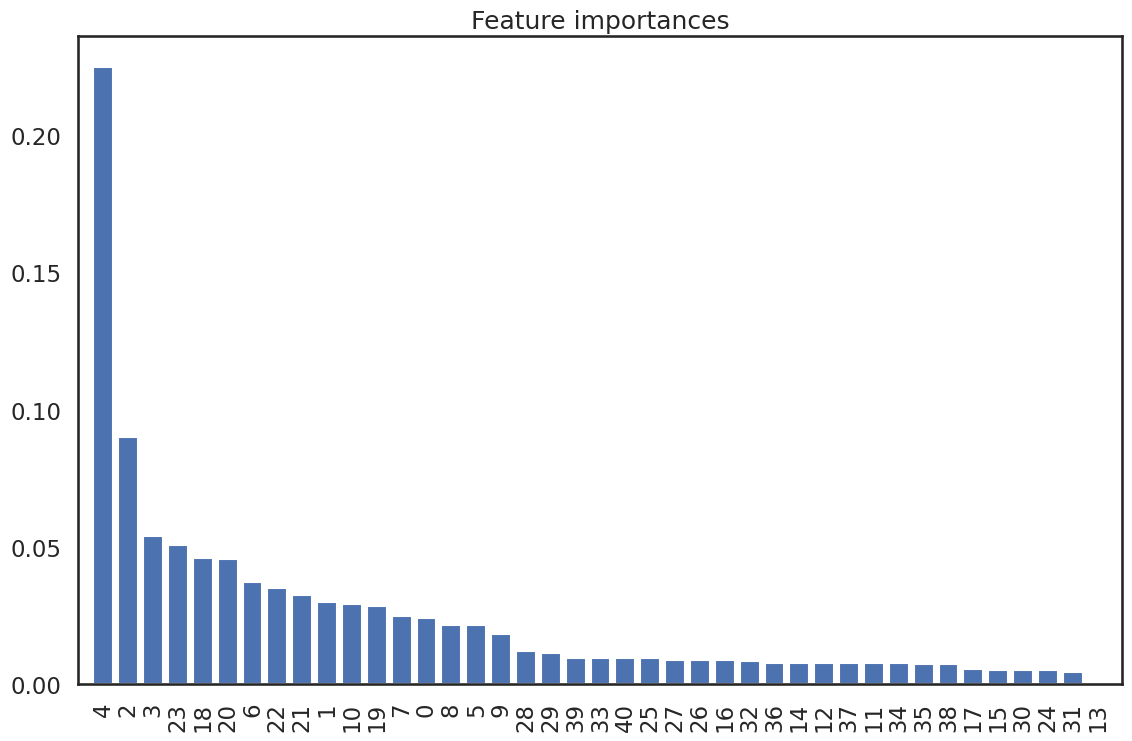

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,f1_score
rf = RandomForestClassifier(n_estimators=1000,max_depth=25)
rf.fit(x_train,y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Візуалізація важливості ознак
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), indices, rotation=90)
plt.xlim([-1, len(importances)])
plt.show()


In [ ]:
important_features = x_train.columns[indices[:15]]
x_train_reduced = x_train[important_features]
x_test_reduced = x_test[important_features]

rf_reduced = RandomForestClassifier(n_estimators=100, max_depth=10)
rf_reduced.fit(x_train_reduced, y_train)
y_pred_reduced = rf_reduced.predict(x_test_reduced)
print(classification_report(y_true=y_test, y_pred=y_pred_reduced))
print(f1_score(y_true=y_test, y_pred=y_pred_reduced, average='macro'))

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
# y_pred = rf.predict(x_test)
# print(classification_report(y_true=y_test,y_pred=y_pred))
# print(f1_score(y_true=y_test,y_pred=y_pred,average='macro'))

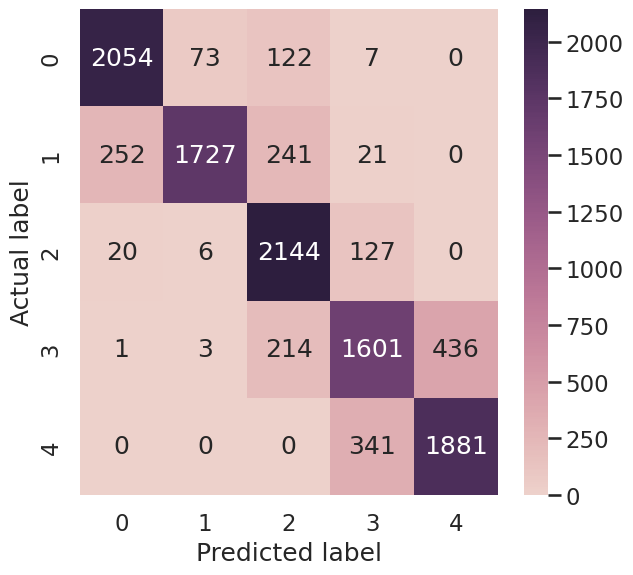

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=y_test,y_pred=y_pred_reduced)
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g', cmap = sns.cubehelix_palette(as_cmap=True))
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,100,100))
mlp.fit(x_train,y_train)
y_pred = mlp.predict(x_test)
print(classification_report(y_true=y_test,y_pred=y_pred))
print(f1_score(y_true=y_test,y_pred=y_pred,average='macro'))

              precision    recall  f1-score   support

           1       0.84      0.92      0.88      2256
           2       0.86      0.82      0.84      2241
           3       0.81      0.76      0.78      2297
           4       0.72      0.71      0.72      2255
           5       0.80      0.80      0.80      2222

    accuracy                           0.80     11271
   macro avg       0.80      0.80      0.80     11271
weighted avg       0.80      0.80      0.80     11271

0.8040925502630503


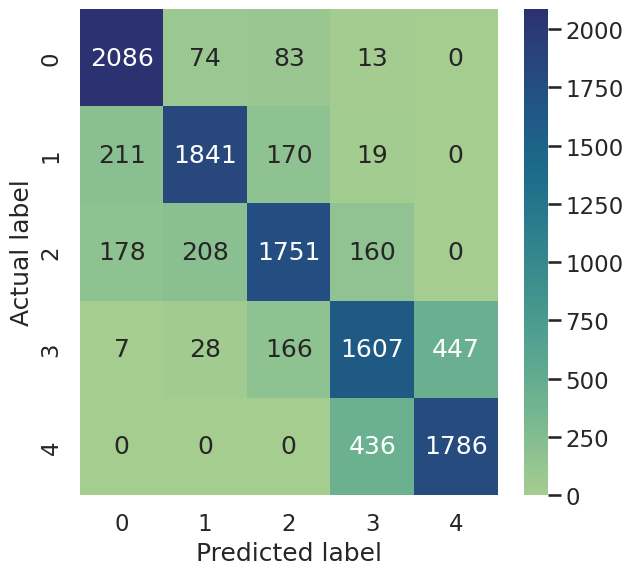

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g', cmap = 'crest')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy',max_depth=15, min_samples_split=10, min_samples_leaf=12)
tree.fit(x_train,y_train)
y_pred = tree.predict(x_test)
print(classification_report(y_true=y_test,y_pred=y_pred))
print(f1_score(y_true=y_test,y_pred=y_pred,average='macro'))

              precision    recall  f1-score   support

           1       0.83      0.82      0.82      2256
           2       0.83      0.72      0.77      2241
           3       0.75      0.87      0.81      2297
           4       0.73      0.74      0.74      2255
           5       0.82      0.80      0.81      2222

    accuracy                           0.79     11271
   macro avg       0.79      0.79      0.79     11271
weighted avg       0.79      0.79      0.79     11271

0.7901035319938358


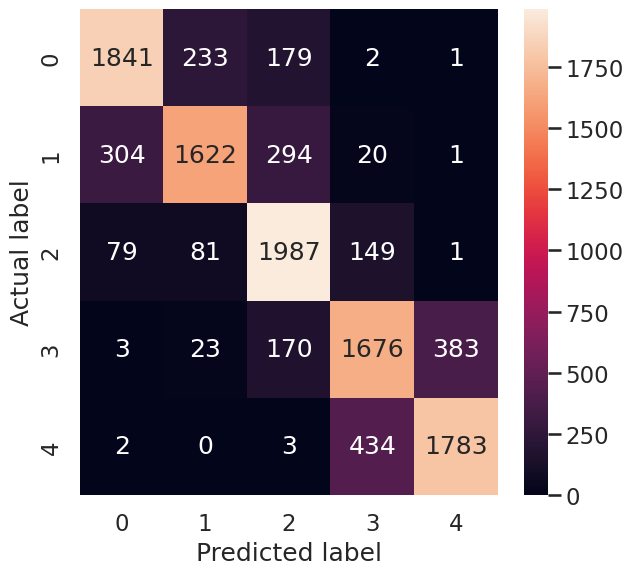

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(n_estimators=100,max_depth=10,min_samples_leaf = 4, min_samples_split= 5)
gbrt.fit(x_train,y_train)
y_pred = gbrt.predict(x_test)
print(classification_report(y_true=y_test,y_pred=y_pred))
print(f1_score(y_true=y_test,y_pred=y_pred,average='macro'))

              precision    recall  f1-score   support

           1       0.92      0.92      0.92      2256
           2       0.96      0.82      0.88      2241
           3       0.81      0.92      0.86      2297
           4       0.74      0.74      0.74      2255
           5       0.81      0.82      0.82      2222

    accuracy                           0.84     11271
   macro avg       0.85      0.84      0.84     11271
weighted avg       0.85      0.84      0.84     11271

0.8435277965994811


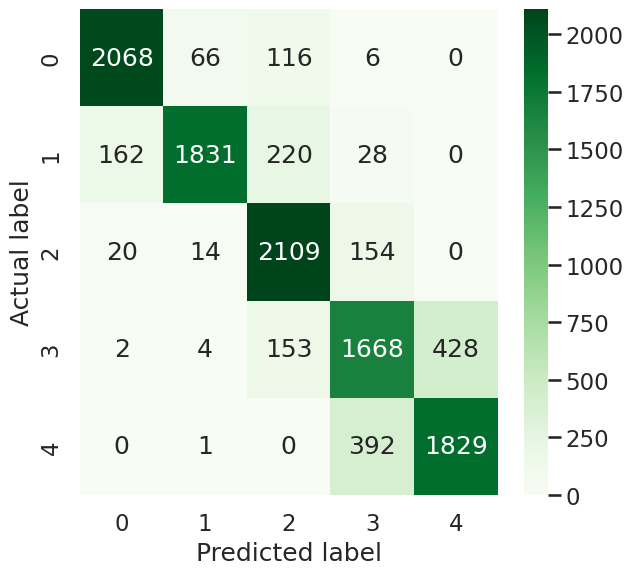

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g', cmap = 'Greens')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

In [ ]:
from xgboost import XGBClassifier
xgb_churn = XGBClassifier(n_jobs=-1,n_estimators=1000,max_depth=10)
y_train_adjusted  = y_train - 1
xgb_churn.fit(x_train,y_train_adjusted )
y_pred = xgb_churn.predict(x_test)
y_pred_adjusted  = y_pred + 1
print(classification_report(y_true=y_test,y_pred=y_pred_adjusted))
print(f1_score(y_true=y_test,y_pred=y_pred_adjusted ,average='macro'))

              precision    recall  f1-score   support

           1       0.93      0.93      0.93      2184
           2       0.96      0.85      0.90      2306
           3       0.82      0.90      0.86      2258
           4       0.74      0.77      0.75      2278
           5       0.83      0.81      0.82      2245

    accuracy                           0.85     11271
   macro avg       0.85      0.85      0.85     11271
weighted avg       0.85      0.85      0.85     11271

0.8520823321147446


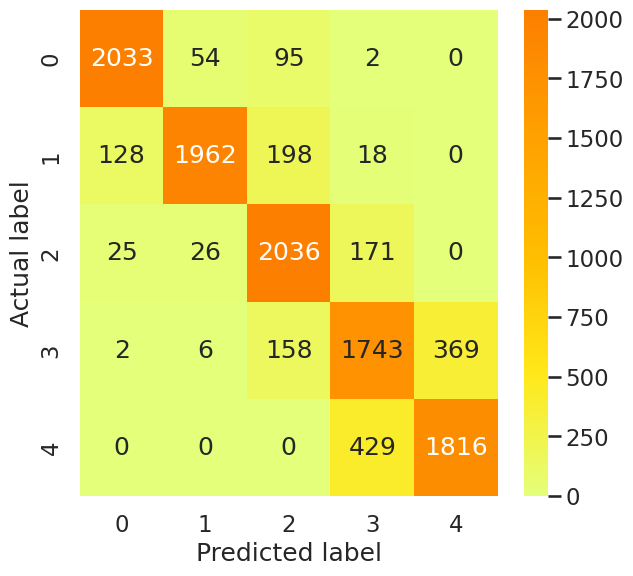

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=y_test,y_pred=y_pred_adjusted)
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g',cmap = 'Wistia')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

In [ ]:
# Збереження RandomForestClassifier
joblib.dump(rf, 'random_forest_model.pkl')

# Збереження MLPClassifier
joblib.dump(mlp, 'mlp_classifier_model.pkl')

# Збереження DecisionTreeClassifier
joblib.dump(tree, 'decision_tree_model.pkl')

# Збереження GradientBoostingClassifier
joblib.dump(gbrt, 'gradient_boosting_model.pkl')

# Збереження XGBClassifier
joblib.dump(xgb_churn, 'xgboost_classifier_model.pkl')

['xgboost_classifier_model.pkl']

In [ ]:
# class MixModel(skb.BaseEstimator, skb.RegressorMixin, skb.TransformerMixin):

#     def __init__(self, algs):
#         self.algs = algs

#     def fit(self, X, y):
#         self.algs_ = [skb.clone(x) for x in self.algs]


#         for alg in self.algs_:
#             alg.fit(X, y)

#         return self


#     def predict(self, X):
#         predictions = np.column_stack([
#             stacked_model.predict(X) for stacked_model in self.algs_
#         ])
#         return (np.mean(predictions, axis=1)).astype('int64')

In [ ]:
# mixed_model = MixModel(algs = [xgb,rf,gbrt])
# mixed_model.fit(x_train, y_train)


In [ ]:
# y_pred = mixed_model.predict(x_test)
# print(classification_report(y_true=y_test,y_pred=y_pred))
# print(f1_score(y_true=y_test,y_pred=y_pred,average='macro'))

In [ ]:
# fig = plt.figure(figsize=(6, 6))
# ax= plt.subplot()
# cm = confusion_matrix(y_true=y_test,y_pred=y_pred)
# sns.heatmap(cm, annot=True, ax = ax, fmt = 'g', cmap = 'Greys')
# ax.set_xlabel('Predicted label')
# ax.set_ylabel('Actual label')
# plt.show()

In [ ]:
def preload_for_test(curr_df):

  curr_df.drop(['customer_id', 'Name', 'security_no', 'referral_id'], axis=1, inplace=True)
  curr_df['avg_frequency_login_days'].replace(['Error'], np.nan, inplace=True)
  curr_df['avg_frequency_login_days'] = curr_df['avg_frequency_login_days'].astype('float64')


  curr_df['joining_date'] = pd.to_datetime(curr_df['joining_date'])
  curr_df['last_visit_time'] = pd.to_datetime(curr_df['last_visit_time'])

  curr_df['jday'] = curr_df['joining_date'].dt.day


  curr_df['jday'] = curr_df['joining_date'].dt.day
  curr_df['jmonth'] = curr_df['joining_date'].dt.month
  curr_df['jweek'] = curr_df['joining_date'].dt.dayofweek
  curr_df['diff'] = ((curr_df['last_visit_time'] - curr_df['joining_date']).apply(lambda x: str(x).split()[0])).astype('float64')



  sm = ['gender','region_category','membership_category','joined_through_referral',
      'preferred_offer_types','medium_of_operation','internet_option','used_special_discount',
       'offer_application_preference']
  df_sm = df[sm]
  curr_df_sm = curr_df[sm]

  df_sm = pd.get_dummies(df_sm)
  curr_df_sm = pd.get_dummies(curr_df_sm)

  ss = ['days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days',
          'points_in_wallet', 'used_special_discount', 'churn_risk_score','sentiment', 'sent_score', 'jday', 'jmonth', 'jweek', 'diff']
  df_ss = df[ss]
  ss_t = ['days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days',
            'points_in_wallet', 'used_special_discount','sentiment', 'sent_score', 'jday', 'jmonth', 'jweek', 'diff']

  curr_df_ss = curr_df[ss_t]
  print(curr_df_ss.shape)
  # Concatenating the dummy columns and numerical feature columns into a new dataframe
  df_new = pd.concat([df_ss, df_sm], axis=1)
  print(df_new.shape)
  curr_df_new = pd.concat([curr_df_ss, curr_df_sm], axis=1)

  curr_df_new.drop(['used_special_discount'], axis=1, inplace=True)

  curr_df_new['avg_frequency_login_days'].fillna(value=curr_df_new['avg_frequency_login_days'].mean(), inplace=True)
  curr_df_new['points_in_wallet'].fillna(value=curr_df_new['points_in_wallet'].mean(), inplace=True)
  missing_columns = []
  for element in df_test_new.columns:
    if element not in curr_df_new.columns:
      missing_columns.append(element)
  losted_sun = pd.DataFrame(columns=missing_columns)

  curr_df_new = pd.concat([curr_df_new,losted_sun],axis=1)
  losted_sun = curr_df_new[missing_columns]
  curr_df_new = curr_df_new.drop(missing_columns, axis=1)
  losted_sun.fillna(value=np.uint8(0), inplace=True)
  losted_sun.index = curr_df_new.index
  curr_df_new = pd.concat([curr_df_new,losted_sun],axis=1)

  output_array = curr_df_new.values
  output_array = scaler.transform(output_array)


  return output_array

In [ ]:
df_demo = pd.read_csv('/content/drive/MyDrive/churn_prediction/data/customers/churn_test.csv')
df_demo = df_demo.iloc[:20]
df_demo = df_demo.rename(columns={'content':'feedback'})
df_demo['region_category'] = df_demo['region_category'].fillna('Other')
df_demo['avg_transaction_value'] = df_demo['avg_transaction_value'].apply(lambda x: x*0.01)
to_sentiment_df_demo = pd.DataFrame(df_demo[['feedback','summary']], columns=['feedback','summary'])
to_sentiment_df_demo = to_sentiment_df_demo.rename(columns={'feedback':'content'})

In [ ]:
output_sentiment_df_demo = sentiment_feedback(to_sentiment_df_demo)

In [ ]:
output_sentiment_df_demo.index = df_demo.index
df_demo = pd.concat([df_demo,output_sentiment_df_demo], axis=1)
df_demo=df_demo.drop('Unnamed: 0', axis=1)
df_demo=df_demo.drop('sentiments', axis=1)

In [ ]:
client_score = pd.DataFrame(xgb_churn.predict(preload_for_test(df_demo)), columns=['churn_risk_score'])

(20, 12)
(25668, 43)


In [ ]:
client_score.head()

,churn_risk_score
0,4
1,2
2,4
3,4
4,2


In [ ]:
df_demo = pd.read_csv('/content/drive/MyDrive/churn_prediction/data/customers/churn_test.csv')
df_demo = df_demo.iloc[:20]
df_demo = df_demo.rename(columns={'content':'feedback'})
df_demo['region_category'] = df_demo['region_category'].fillna('Other')
df_demo['avg_transaction_value'] = df_demo['avg_transaction_value'].apply(lambda x: x*0.01)
to_sentiment_df_demo = pd.DataFrame(df_demo[['feedback','summary']], columns=['feedback','summary'])
to_sentiment_df_demo = to_sentiment_df_demo.rename(columns={'feedback':'content'})
output_sentiment_df_demo.index = df_demo.index
df_demo = pd.concat([df_demo,output_sentiment_df_demo], axis=1)
df_demo=df_demo.drop('Unnamed: 0', axis=1)
df_demo=df_demo.drop('sentiments', axis=1)

In [ ]:
df_pr = pd.DataFrame(df_demo['customer_id'],columns=['customer_id'])

In [ ]:
df_pr = pd.concat([df_demo,client_score],axis=1)
df_pr

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,feedback,summary,sentiment,sent_score,churn_risk_score
0,fffe43004900440035003700330030003600,Evelyne Kinch,17,M,NBV1O8W,Town,Basic Membership,2016-12-04,Yes,CID53746,...,99.4854,16.0,577.830000,Yes,No,I just want to say that most Meguiar's product...,half of the product leaked before opening...di...,1,0.941271,4
1,fffe4300490044003500320033003500,Franklin Lurry,22,M,C3B77NU,Town,No Membership,2015-10-14,Yes,CID60228,...,193.6360,Error,528.660000,Yes,No,This item is misrepresented. Meguiar's no lon...,Meguiar's Gold Class Clear Coat Wax,0,0.944350,2
2,fffe43004900440036003100310035003800,Alan Branum,17,M,OCHQG0L,Village,Basic Membership,2016-01-21,No,xxxxxxxx,...,489.1395,24.0,613.790000,Yes,Yes,Leaves film on car after wash,One Star,1,0.999249,4
3,fffe43004900440035003700380032003700,Elke Yann,55,F,4KPKRVX,Town,Basic Membership,2015-12-11,No,xxxxxxxx,...,307.7381,Error,520.360000,No,Yes,"Soap is soap regardless of manufacturer ,who c...",Give me a break,0,0.921420,4
4,fffe43004900440034003900360037003200,Nichelle Oceguera,18,F,M0ZT1CU,City,Basic Membership,2016-04-28,?,CID56250,...,281.1233,22.0,523.410000,Yes,No,"I purchased 2 bottles, finished the first bott...",Diluted Liquid Soap!,1,0.991612,2
5,fffe43004900440035003800370036003400,Opal Robards,57,M,QPMH483,Other,Basic Membership,2017-08-17,Yes,CID22216,...,87.8412,26.0,660.360000,No,Yes,Stinks like perfume !,Hate,1,0.953655,2
6,fffe43004900440032003300330039003400,Audry Yarber,12,M,RHTAOKV,City,Basic Membership,2016-07-17,Yes,xxxxxxxx,...,105.1017,7.0,642.800000,Yes,No,bottle was leaking half of its contents....,One Star,1,0.999967,2
7,fffe43004900440032003100320032003500,Alayna Patt,40,M,6NQQSL9,Town,Basic Membership,2016-05-16,No,xxxxxxxx,...,334.0972,14.0,NaN,Yes,No,Would have been ok but bottle had hole in top ...,hole in product,0,0.999160,3
8,fffe43004900440032003700360038003800,Fumiko Tracey,14,F,RPGA9Y5,Town,Basic Membership,2015-02-16,Yes,CID45738,...,310.0134,29.0,627.990000,Yes,No,Absolutely no suds when pumped through my pres...,Not Compatible With Pressure Washers.,0,0.948495,2
9,fffe43004900440035003200370033003500,Colby Omalley,16,M,48BNSWF,Town,No Membership,2017-08-15,No,xxxxxxxx,...,497.5783,23.0,681.700000,Yes,No,"I don't see what all the excitement is about, ...",Water marks/white film,0,0.965484,4


In [ ]:
hight_churn_risk = df_pr[(df_pr['sentiment']==1)&(df_pr['churn_risk_score'])]
reasons_column = []
for doc in hight_churn_risk['feedback'].tolist():
  nlp_doc = nlp(doc)
  reasons_list = []
  for ent in nlp_doc.ents:
    reason = str(ent.text) + " - " + str(ent.label_)
    reasons_list.append(reason)
  reason_str = ';'.join(reasons_list)
  reasons_column.append(reason_str)
reasons_column = pd.DataFrame(reasons_column, columns=['reasons'])
reasons_column.index = hight_churn_risk.index
hight_churn_risk = pd.concat([hight_churn_risk,reasons_column], axis=1)
hight_churn_risk

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,feedback,summary,sentiment,sent_score,churn_risk_score,reasons
14,fffe43004900440033003800340037003700,Damaris Zamorano,23,F,6X94SCD,Town,No Membership,2016-04-25,No,xxxxxxxx,...,-6.860127860435156,663.97,Yes,No,Very disappointed in this product- not very we...,disappointed!,1,0.99689,3,
